# Mortalidad por COVID-19 en el Perú


## 1. Objetivos

* Determinar las tasa de mortalidad del COVID-19 a nivel distrial.
* Elaborar un mapa de Mortalidad por COVID-19 en el Perú

## 2. Fuente de datos

Para la elaboración del proyecto utilizaremos la siguiente información:

1. Población al 2021 - INEI
2. Fallecidos por COVID-19 - MINSA
3. Capa vectorial de Distritos del Perú - INEI

Los dos primeros conjuntos de datos se descargan de forma directa desde la página de [Datos Abiertos](https://www.datosabiertos.gob.pe/dataset/poblaci%C3%B3n-peru) del Perú. 

La capa de **distritos** se obtiene a partir del servicio **WFS** que se encuentra publicado en la página de [Infraestructura de Datos Espaciales del Perú (IDEP)](https://geoidep.gob.pe/servicios-idep/servicios-de-publicacion-de-objetos-wfs) y cuya fuente oficial es el INEI

## 3. Desarrollo

### 3.1. Importar librerías

Como primer paso vamos a importar las librerias que utilizaremos para el desarrollo del proyecto

In [1]:
# Importar librerias
import pandas as pd
import geopandas as gpd
import requests
import json
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt
import numpy as np
print('Realizado')

Realizado


### 3.2. Lectura de los datos

Todos los datos descargadoa seran convertidos en DataFrame. Comenzaremos con los archivos de descarga directa (se descagran en formato csv)

* Agregar encabezados de página para evitar rechazos a las solicitudes:

In [2]:
# encabezados
hdr = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) ' +
       'AppleWebKit/537.36 (KHTML, like Gecko) ' +
       'Chrome/50.0.2661.102 Safari/537.36'}
hdr

{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

#### 3.2.1. Obtener población

Seguir los siguientes pasos:
* Tener la URL de descarga
* Realizar la solicitud a la URL
* Descargar los datos localmente (en la PC) y almacenar el contenido en una variable
* Convertir el contenido de la descarga en un DataFrame

In [3]:
# URL Poblacion: Data en formato CSV de descarga directa
url_pob = 'https://cloud.minsa.gob.pe/s/Jwck8Z59snYAK8S/download'

# Realizar solicitud
response_pob = requests.get(url_pob, headers = hdr)

# Descargar datos
file_pob = './poblacion.csv' # para almacenar el contenido
open(file_pob, 'wb').write(response_pob.content)

# Convertir a DataFrame
df_pob = pd.read_csv(file_pob, encoding='UTF-8', dtype={'ubigeo_inei':str})
df_pob.sample(3)

,ubigeo_reniec,ubigeo_inei,Departamento,Provincia,Distrito,Edad_Anio,Sexo,Cantidad
103773,21205,021707,ANCASH,RECUAY,PAMPAS CHICO,65-69,F,32
108868,10408,010508,AMAZONAS,LUYA,LONYA CHICO,8,F,9
15161,110211,120211,JUNIN,CONCEPCION,MITO,4,F,7


In [4]:
# dimension (filas y columnas):
df_pob.shape

(123684, 8)

#### 3.2.2. Obtener fallecimientos por COVID-19

Repetiremos los pasos del puntos 3.2.1

In [5]:
# Covid: Data en formato CSV de descarga directa
url_cov = 'https://files.minsa.gob.pe/s/t9AFqRbXw3F55Ho/download'

# Realizar solicitud
response_cov = requests.get(url_cov, headers = hdr)

# Descargar datos
file_cov = './covid.csv'  # para almacenar el contenido
open(file_cov, 'wb').write(response_cov.content)

# Convertir a DataFrame
df_cov = pd.read_csv(file_cov, sep=';', encoding='UTF-8', dtype={'UBIGEO':str})
df_cov.sample(3)

,FECHA_CORTE,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,CLASIFICACION_DEF,DEPARTAMENTO,PROVINCIA,DISTRITO,UBIGEO,UUID
191202,20220916,20200516,72,MASCULINO,Criterio SINADEF,LIMA,LIMA,CARABAYLLO,150106,36920637.0
190903,20220916,20200429,82,FEMENINO,Criterio SINADEF,LORETO,MAYNAS,PUNCHANA,160108,36920121.0
5274,20220916,20210419,51,MASCULINO,Criterio virolÃ³gico,LIMA,LIMA,COMAS,150110,15717610.0


In [6]:
# dimension (filas y columnas):
df_cov.shape

(216287, 10)

#### 3.2.3. Obtener capa de Distrito

Esta capa se obtendra a partir del servicio WFS publicado en el IDEP:
* Tener la URL del servicio WFS
* Inicializar el WFS
* Obtener la última capa disponible
* Realizar la solicitud al WFS (con los parámetros solicitados por el servicio)
* Convertir la respuesta del servicio en un GeoDataFrame


>Nota: Para obtener los metadatos del servicio podemos realizar la siguiente petición **GetCapabilities**
https://maps.inei.gob.pe/geoserver/T10Limites/ig_distrito/ows?service=wfs&version=2.0.0&request=GetCapabilities


In [7]:
# URL del servicio WFS
url_dis = 'https://maps.inei.gob.pe/geoserver/T10Limites/ig_distrito/ows'

# Inicializar WFS
wfs_dis = WebFeatureService(url_dis)

# Obtener la ultima capa disponible
layer_dis = list(wfs_dis.contents)[-1]

# Completar los parámetros de solicitud del servicio
params = {'service':'WFS',
          'version':'2.0.0', 
          'request':'GetFeature',
          'typeName':layer_dis,
          'outputFormat':'json'}

# Realizar solicitud al servicio WFS (Retornará un JSON)
response_dis = requests.Request('GET', url_dis, params=params).prepare().url

# Convertir JSON a GeodataFrame
gdf_dis = gpd.read_file(response_dis)
gdf_dis.sample(3)

,id,capital,nombdep,nombprov,nombdist,ubigeo,tematica,ccdd,ccpp,idprov,fuente,ccdi,id_geografia,geometry
16,ig_distrito.42,Locumba,Tacna,Jorge Basadre,Locumba,230301,T10,23,03,2303,INEI - CPV2017 RESULTADOS,01,4230301,"MULTIPOLYGON (((-70.50890 -17.54534, -70.50938..."
1680,ig_distrito.1392,Ongon,La Libertad,Pataz,Ongon,130807,T10,13,08,1308,INEI - CPV2017 RESULTADOS,07,4130807,"MULTIPOLYGON (((-77.06870 -8.03951, -77.07034 ..."
473,ig_distrito.1584,Colasay,Cajamarca,Jaén,Colasay,060804,T10,06,08,0608,INEI - CPV2017 RESULTADOS,04,4060804,"MULTIPOLYGON (((-78.97052 -5.69681, -78.97434 ..."


<AxesSubplot:>

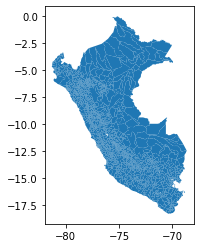

In [8]:
# Plotear distritos
gdf_dis.plot()

### 3.3. Resumir datos a nivel de distrito (ubigeo)

Ahora es necesario a resumir toda la información obtenida a nivel de distrito para realizar las estadisticas y el mapa solicitado. Utilizaremos el campo de código de UBIGEO (en formato INEI) como identificador del distrito.

* Poblacion total por Ubigeo

In [9]:
df_pob_ubigeo = pd.DataFrame(df_pob.groupby(['ubigeo_inei'])['Cantidad'].sum())
df_pob_ubigeo.rename(columns={'Cantidad':'poblacion'}, inplace = True)
df_pob_ubigeo.head(3)

,poblacion
ubigeo_inei,
010101,29041
010102,291
010103,1639


* Total de fallecidos por COVID-19 por Ubigeo 

In [10]:
df_cov_ubigeo = pd.DataFrame(df_cov.groupby(['UBIGEO']).size())
df_cov_ubigeo.rename(columns={0:'fallecidos'}, inplace = True)
df_cov_ubigeo.drop(index='.', inplace = True)
df_cov_ubigeo.head(3)

,fallecidos
UBIGEO,
010101,208
010103,3
010105,2


### 3.4. Unir reportes a la capa de Distrito

Realizar la únion utilizando el campo **ubigeo** como identificador para todas las bases.

Para realizar el **join** es necesario considerar que para la capa de **distritos** el ubigeo es un campo y para la población y fallecidos por covid es el índice del marco de datos. 

In [11]:
# Join 1: distrito y poblacion total
gdf_dis = gdf_dis.merge(df_pob_ubigeo, how='left',left_on='ubigeo', right_index=True)

# Join 2: Join 1 y fallecidos por covid
gdf_dis = gdf_dis.merge(df_cov_ubigeo, how='left',left_on='ubigeo', right_index=True)

gdf_dis[['ubigeo','poblacion','fallecidos','geometry']].sample(5)

,ubigeo,poblacion,fallecidos,geometry
83,040304,1073,3.0,"MULTIPOLYGON (((-74.19374 -15.49166, -74.19450..."
261,030303,1599,4.0,"MULTIPOLYGON (((-72.63622 -14.35623, -72.63747..."
100,100510,3578,4.0,"MULTIPOLYGON (((-76.83681 -9.26348, -76.83824 ..."
857,200702,7274,75.0,"MULTIPOLYGON (((-80.90893 -4.22452, -80.91014 ..."
602,050114,17439,15.0,"MULTIPOLYGON (((-74.38568 -13.15052, -74.38648..."


### 3.5. Calcular tasa de mortalidad por COVID

Para realizar el cálculo de la tasa de mortalidad utilizaremos la siguiente formula

> **Tasa de mortalidad = (N° de Fallecidos $\div$ Población Media) $\times$ 1000**

In [26]:
gdf_dis['tasa_mortalidad'] = (gdf_dis.fallecidos/gdf_dis.poblacion)*1000
gdf_dis[['ubigeo','nombdist','nombprov','nombdep','tasa_mortalidad']].sample(5)

,ubigeo,nombdist,nombprov,nombdep,tasa_mortalidad
1657,060502,Chilete,Contumazá,Cajamarca,9.259259
1701,021705,Llacllín,Recuay,Ancash,2.717391
328,100401,Huacaybamba,Huacaybamba,Huánuco,2.552048
923,040806,Puyca,La Unión,Arequipa,3.385240
43,210403,Huacullani,Chucuito,Puno,0.165968


## 4. Resultados

Para visualizar los resultados utilizaremos  Histogramas y un mapa graduado de la tasa de Mortalidad

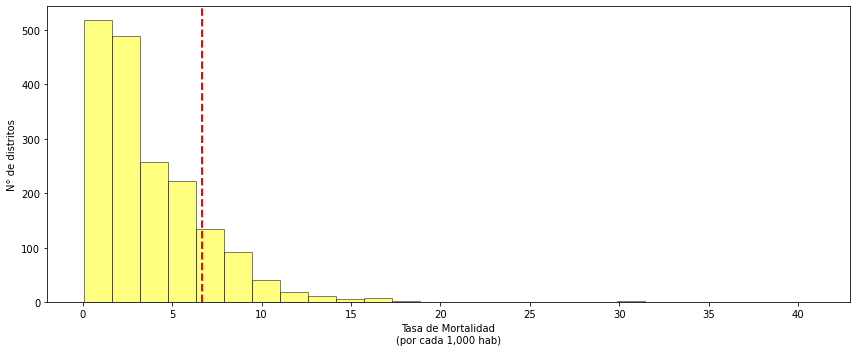

In [82]:
# Determinar el número de clases
k = int(np.round(1 + 3.322*np.log(len(gdf_dis)),0))

# Tasa de mortalidad a nivel nacional:
tasa_mortalidad_nacional = (gdf_dis.fallecidos.sum()/gdf_dis.poblacion.sum())*1000

# Graficar Histograma
fig, ax = plt.subplots(1, figsize=(12,5))
ax.hist(gdf_dis.tasa_mortalidad, bins=k, color='Yellow', alpha=0.5, edgecolor='Black') # Histograma
ax.axvline(x = tasa_mortalidad_nacional, color='r', lw=2, ls='--') # tasa de mortalidad a nivel nacional
ax.set_ylabel('N° de distritos')
ax.set_xlabel('Tasa de Mortalidad\n(por cada 1,000 hab)')
fig.tight_layout()
plt.show()

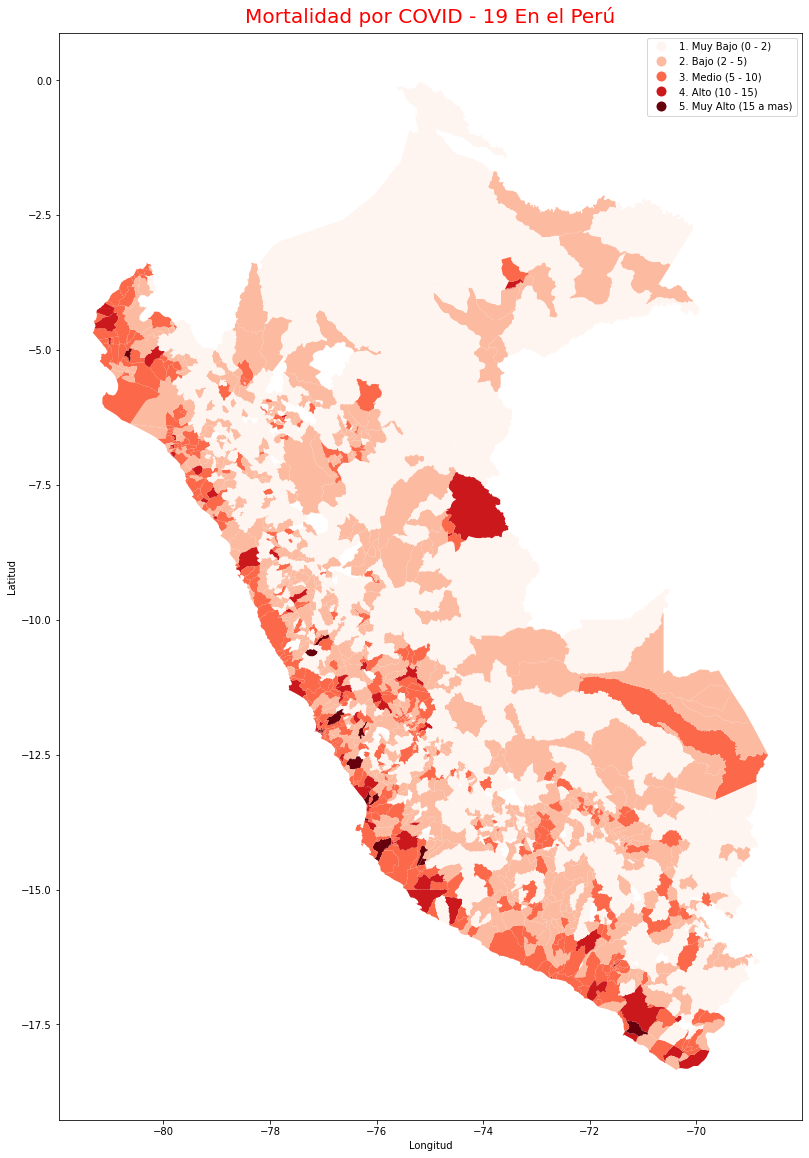

In [144]:
# Reclasificación de Tasa de Mortalidad
dic_reclass = {0:'1. Muy Bajo (0 - 2)',
               2:'2. Bajo (2 - 5)',
               5:'3. Medio (5 - 10)',
               10:'4. Alto (10 - 15)',
               15:'5. Muy Alto (15 a mas)'}

for key in dic_reclass:
    gdf_dis.loc[gdf_dis.tasa_mortalidad >= key, 'tasa_reclass'] = dic_reclass[key]

# Tamaño de la figura del mapa
fig_map, ax_map = plt.subplots(figsize=(20, 20))
 
# Título y los ejes
ax_map.set_title('Mortalidad por COVID - 19 En el Perú', pad = 10, fontdict={'fontsize':20, 'color': 'r'})
ax_map.set_xlabel('Longitud')
ax_map.set_ylabel('Latitud')
 
# Mostrar Mapa
gdf_dis.plot(column='tasa_reclass', cmap='Reds', ax=ax_map, zorder=10,
            legend=True)

plt.show()

### Descargo de Responsabilidad:

Toda la información y enlaces de este sitio web provienen de fuentes públicas Oficiales del Estado del Perú. El autor NO acepta ninguna responsabilidad por las posibles consecuencias, intencionadas o no, de las acciones realizadas mediante el uso de los materiales expuestos.

Las metodologías y resultados presentados en este tutorial tienen un fin netamente didactico, de ninguna manera pretende reemplazar las metodologías y estadísticas oficiales presentandas por el Estado Peruano. El autor NO se hace responsable del uso y aplicación de los resutaldos presentandos en este tutorial.

### Referencias

https://www.gob.pe/idep

https://www.datosabiertos.gob.pe/

### Contacto

* Autor: @Charlie Lopez Rengifo

* Email: chlopezgis@gmail.com

* Telefono: +51900502734
